# Experiment 2: Complex PyTorch for Music Genre Classification

In [1]:
# Complex pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from complexPyTorch.complexLayers import *
from complexPyTorch.complexFunctions import *

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load Data
import numpy as np
import json
import os
import math
import librosa
import pathlib
from scipy.spatial.distance import cdist
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import random

# MFCCS
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window

In [27]:
def train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict, complexify=True, data_fn = None):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = len(train_loader.dataset)
    start_time = time.time()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        if complexify: data = data.type(torch.complex64)
        if data_fn != None: data = data_fn(data)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 10 == 0:
            batch_accuracy = 100. * correct / ((batch_idx + 1) * len(data))
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch,
                batch_idx * len(data),
                total_samples,
                100. * batch_idx / len(train_loader),
                loss.item(),
                batch_accuracy)
            )
    
    end_time = time.time()
    epoch_times = metrics_dict['epoch_times']
    epoch_times.append(end_time - start_time)
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total_samples
    train_losses = metrics_dict['train_losses']
    train_accuracies = metrics_dict['train_accuracies']
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print('Epoch {} - Time: {:.2f}s - Train Loss: {:.6f} - Train Accuracy: {:.2f}%'.format(epoch, epoch_times[-1], epoch_loss, epoch_accuracy))
    
    # Evaluate on test data
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if complexify:
                data = data.type(torch.complex64)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses = metrics_dict['test_losses']
    test_accuracies = metrics_dict['test_accuracies']
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))

### Data Preparation

In [ ]:
DATASET_PATH = "data/music_genre_binary_data/train"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
BATCH_SIZE = 64
NUM_EPOCHS = 20 

In [29]:
genre_list = os.listdir(DATASET_PATH)
if '.DS_Store' in genre_list: genre_list.remove('.DS_Store')
genre_mappings = dict(zip(genre_list, range(len(genre_list))))
print(genre_mappings)

{'classical': 0, 'rock': 1}


### MFCCS

In [55]:
class MusicFeatureExtractor:
    def __init__(self, FFT_size=2048, HOP_SIZE=512, mel_filter_num=13, dct_filter_num=40):
        self.FFT_size = FFT_size
        self.HOP_SIZE = HOP_SIZE
        self.mel_filter_num = mel_filter_num
        self.dct_filter_num = dct_filter_num
        self.epsilon = 1e-10  # Added to log to avoid log10(0)

    def normalize_audio(self, audio):
        audio = audio / np.max(np.abs(audio))
        return audio

    def frame_audio(self, audio):
        frame_num = int((len(audio) - self.FFT_size) / self.HOP_SIZE) + 1
        frames = np.zeros((frame_num, self.FFT_size))
        for n in range(frame_num):
            frames[n] = audio[n * self.HOP_SIZE: n * self.HOP_SIZE + self.FFT_size]
        return frames

    def freq_to_mel(self, freq):
        return 2595.0 * np.log10(1.0 + freq / 700.0)

    def met_to_freq(self, mels):
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

    def get_filter_points(self, fmin, fmax, sample_rate):
        fmin_mel = self.freq_to_mel(fmin)
        fmax_mel = self.freq_to_mel(fmax)
        mels = np.linspace(fmin_mel, fmax_mel, num=self.mel_filter_num + 2)
        freqs = self.met_to_freq(mels)
        return np.floor((self.FFT_size + 1) / sample_rate * freqs).astype(int), freqs

    def get_filters(self, filter_points):
        filters = np.zeros((len(filter_points) - 2, int(self.FFT_size / 2 + 1)))
        for n in range(len(filter_points) - 2):
            filters[n, filter_points[n]: filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
            filters[n, filter_points[n + 1]: filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
        return filters

    def dct(self):
        basis = np.empty((self.dct_filter_num, self.mel_filter_num))
        basis[0, :] = 1.0 / np.sqrt(self.mel_filter_num)
        samples = np.arange(1, 2 * self.mel_filter_num, 2) * np.pi / (2.0 * self.mel_filter_num)
        for i in range(1, self.dct_filter_num):
            basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / self.mel_filter_num)
        return basis

    def get_mfcc_features(self, audio, sample_rate):
        audio = self.normalize_audio(audio)
        audio_framed = self.frame_audio(audio)
        window = get_window("hann", self.FFT_size, fftbins=True)
        audio_win = audio_framed * window
        audio_winT = np.transpose(audio_win)
        audio_fft = np.empty((int(1 + self.FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')
        for n in range(audio_fft.shape[1]):
            audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]
        audio_fft = np.transpose(audio_fft)
        audio_fft = np.square(np.abs(audio_fft))
        freq_min = 0
        freq_high = sample_rate / 2
        filter_points, mel_freqs = self.get_filter_points(freq_min, freq_high, sample_rate)
        filters = self.get_filters(filter_points)
        audio_filtered = np.dot(filters, np.transpose(audio_fft))
        audio_filtered = np.maximum(audio_filtered, self.epsilon)  # Replace zero values with epsilon
        audio_log = 10.0 * np.log10(audio_filtered)
        dct_filters = self.dct()
        cepstral_coefficents = np.dot(dct_filters, audio_log)
        return np.array([cepstral_coefficents])

class MusicFeatureExtractorComplex:
    def __init__(self, FFT_size=2048, HOP_SIZE=512, mel_filter_num=13, dct_filter_num=40):
        self.FFT_size = FFT_size
        self.HOP_SIZE = HOP_SIZE
        self.mel_filter_num = mel_filter_num
        self.dct_filter_num = dct_filter_num
        self.epsilon = 1e-10  # Added to log to avoid log10(0)

    def normalize_audio(self, audio):
        audio = audio / np.max(np.abs(audio))
        return audio

    def frame_audio(self, audio):
        frame_num = int((len(audio) - self.FFT_size) / self.HOP_SIZE) + 1
        frames = np.zeros((frame_num, self.FFT_size))
        for n in range(frame_num):
            frames[n] = audio[n * self.HOP_SIZE: n * self.HOP_SIZE + self.FFT_size]
        return frames

    def freq_to_mel(self, freq):
        return 2595.0 * np.log10(1.0 + freq / 700.0)

    def met_to_freq(self, mels):
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

    def get_filter_points(self, fmin, fmax, sample_rate):
        fmin_mel = self.freq_to_mel(fmin)
        fmax_mel = self.freq_to_mel(fmax)
        mels = np.linspace(fmin_mel, fmax_mel, num=self.mel_filter_num + 2)
        freqs = self.met_to_freq(mels)
        return np.floor((self.FFT_size + 1) / sample_rate * freqs).astype(int), freqs

    def get_filters(self, filter_points):
        filters = np.zeros((len(filter_points) - 2, int(self.FFT_size / 2 + 1)))
        for n in range(len(filter_points) - 2):
            filters[n, filter_points[n]: filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
            filters[n, filter_points[n + 1]: filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
        return filters

    def dct(self):
        basis = np.empty((self.dct_filter_num, self.mel_filter_num))
        basis[0, :] = 1.0 / np.sqrt(self.mel_filter_num)
        samples = np.arange(1, 2 * self.mel_filter_num, 2) * np.pi / (2.0 * self.mel_filter_num)
        for i in range(1, self.dct_filter_num):
            basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / self.mel_filter_num)
        return basis

    def get_mfcc_features(self, audio, sample_rate):
        audio = self.normalize_audio(audio)
        audio_framed = self.frame_audio(audio)
        window = get_window("hann", self.FFT_size, fftbins=True)
        audio_win = audio_framed * window
        audio_winT = np.transpose(audio_win)
        audio_fft = np.empty((int(1 + self.FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')
        for n in range(audio_fft.shape[1]):
            audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]
        audio_fft = np.transpose(audio_fft)
        # audio_fft = np.square(audio_fft) ######## new line
        freq_min = 0
        freq_high = sample_rate / 2
        filter_points, mel_freqs = self.get_filter_points(freq_min, freq_high, sample_rate)
        filters = self.get_filters(filter_points)
        audio_filtered = np.dot(filters, np.transpose(audio_fft))  
        audio_filtered[audio_filtered == 0] = self.epsilon # Replace zero values with epsilon
        audio_log = 10.0 * np.log10(audio_filtered)
        dct_filters = self.dct()
        cepstral_coefficents = np.dot(dct_filters, audio_log)
        return np.array([cepstral_coefficents])

In [51]:
class GenreDatasetMFCC(Dataset):

    def __init__(self, train_path, n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=40, training = True):
        cur_path = pathlib.Path(train_path)
        self.files = []
        for i in list(cur_path.rglob("*.wav")):
            for j in range(num_segments):
                self.files.append([j, i])
        self.samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.num_segments = num_segments
        self.mfcc_extractor = MusicFeatureExtractor(
            FFT_size=n_fft, HOP_SIZE=hop_length, mel_filter_num = mel_filter_num, dct_filter_num = dct_filter_num)
        self.dct_filter_num = dct_filter_num
        self.training = training

    def apply_augmentations(self, signal):
        # Apply augmentations to the audio signal
        if random.random() < 0.5:
            signal = librosa.effects.pitch_shift(signal, sr=SAMPLE_RATE, n_steps=random.uniform(-2, 2))
        if random.random() < 0.5:
            signal = librosa.effects.time_stretch(signal, rate=random.uniform(0.8, 1.2))
        return signal

    def adjust_shape(self, sequence, max_sequence_length = 126):
        current_length = sequence.shape[2]
        if current_length < max_sequence_length:
            padding = np.zeros((1, 13, max_sequence_length - current_length))
            padded_sequence = np.concatenate((sequence, padding), axis=2)
        else:
            padded_sequence = sequence[:, :, :max_sequence_length]
        return padded_sequence
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        cur_file = self.files[idx]
        d = cur_file[0]
        file_path = cur_file[1]
        target = genre_mappings[str(file_path).split("/")[3]]
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
        start = self.samples_per_segment * d
        finish = start + self.samples_per_segment
        cur_signal = signal[start:finish]
        if self.training: cur_signal = self.apply_augmentations(cur_signal)
        cur_mfcc = self.mfcc_extractor.get_mfcc_features(cur_signal, sample_rate)  # Use the MusicFeatureExtractor to get MFCC features
        cur_mfcc = self.adjust_shape(cur_mfcc)
        return torch.tensor(cur_mfcc, dtype=torch.float32), target


class GenreDatasetPhaseMFCC(GenreDatasetMFCC):

    def __init__(self, train_path, n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=40, training = True):
        super().__init__(train_path, n_fft, hop_length, num_segments, mel_filter_num, dct_filter_num, training)
        self.mfcc_extractor = MusicFeatureExtractorComplex(
            FFT_size=n_fft, HOP_SIZE=hop_length, mel_filter_num = mel_filter_num, dct_filter_num = dct_filter_num)
        
    def __getitem__(self, idx):
        cur_file = self.files[idx]
        d = cur_file[0]
        file_path = cur_file[1]
        target = genre_mappings[str(file_path).split("/")[3]]
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
        start = self.samples_per_segment * d
        finish = start + self.samples_per_segment
        cur_signal = signal[start:finish]
        if self.training: cur_signal = self.apply_augmentations(cur_signal)
        cur_mfcc = self.mfcc_extractor.get_mfcc_features(cur_signal, sample_rate)  # Use the MusicFeatureExtractor to get MFCC features
        cur_mfcc = self.adjust_shape(cur_mfcc)
        return torch.tensor(cur_mfcc, dtype=torch.complex64), target

### 1. No phase data

In [ ]:
train_dataset = GenreDatasetMFCC("data/music_genre_binary_data/train/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13, training = True)
test_dataset = GenreDatasetMFCC("data/music_genre_binary_data/test/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13, training = False)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)

In [33]:
class RealNet(nn.Module):
    
    def __init__(self):
        super(RealNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 2, 1)
        self.bn  = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, 2, 1)
        self.fc1 = nn.Linear(30*2*20, 500)
        self.fc2 = nn.Linear(500, 2)
             
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1,30*2*20)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RealNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e1 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e1,
          complexify = False)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e1.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  1680 (  0%)]	Loss: 0.704849	Accuracy: 40.62%
Train Epoch:   0 [   640/  1680 ( 38%)]	Loss: 0.423925	Accuracy: 68.61%
Train Epoch:   0 [  1280/  1680 ( 77%)]	Loss: 0.234236	Accuracy: 78.20%
Epoch 0 - Time: 128.85s - Train Loss: 0.411608 - Train Accuracy: 79.76%
Test Loss: 0.201619 - Test Accuracy: 94.38%

Train Epoch:   1 [     0/  1680 (  0%)]	Loss: 0.265989	Accuracy: 90.62%
Train Epoch:   1 [   640/  1680 ( 38%)]	Loss: 0.209348	Accuracy: 89.35%
Train Epoch:   1 [  1280/  1680 ( 77%)]	Loss: 0.252733	Accuracy: 90.03%
Epoch 1 - Time: 97.30s - Train Loss: 0.250952 - Train Accuracy: 89.11%
Test Loss: 0.187991 - Test Accuracy: 95.94%

Train Epoch:   2 [     0/  1680 (  0%)]	Loss: 0.184509	Accuracy: 90.62%
Train Epoch:   2 [   640/  1680 ( 38%)]	Loss: 0.221272	Accuracy: 91.90%
Train Epoch:   2 [  1280/  1680 ( 77%)]	Loss: 0.210586	Accuracy: 91.29%
Epoch 2 - Time: 88.58s - Train Loss: 0.226238 - Train Accuracy: 90.65%
Test Loss: 0.191462 - Test Accuracy: 93.44%

Tra

In [34]:
class ComplexNet(nn.Module):
    
    def __init__(self):
        super(ComplexNet, self).__init__()
        self.conv1 = ComplexConv2d(1, 10, 2, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 2, 1)
        self.fc1 = ComplexLinear(30*2*20, 500)
        self.fc2 = ComplexLinear(500, 2)
             
    def forward(self,x):
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(-1,30*2*20)
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e2 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e2)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e2.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  1680 (  0%)]	Loss: 0.787573	Accuracy: 50.00%
Train Epoch:   0 [   640/  1680 ( 38%)]	Loss: 0.266224	Accuracy: 81.25%
Train Epoch:   0 [  1280/  1680 ( 77%)]	Loss: 0.318807	Accuracy: 84.67%
Epoch 0 - Time: 84.48s - Train Loss: 0.332101 - Train Accuracy: 85.06%
Test Loss: 0.288308 - Test Accuracy: 87.50%

Train Epoch:   1 [     0/  1680 (  0%)]	Loss: 0.272093	Accuracy: 90.62%
Train Epoch:   1 [   640/  1680 ( 38%)]	Loss: 0.127081	Accuracy: 89.77%
Train Epoch:   1 [  1280/  1680 ( 77%)]	Loss: 0.268081	Accuracy: 91.59%
Epoch 1 - Time: 3913.69s - Train Loss: 0.210537 - Train Accuracy: 91.19%
Test Loss: 0.215142 - Test Accuracy: 92.50%

Train Epoch:   2 [     0/  1680 (  0%)]	Loss: 0.203816	Accuracy: 92.19%
Train Epoch:   2 [   640/  1680 ( 38%)]	Loss: 0.197076	Accuracy: 93.32%
Train Epoch:   2 [  1280/  1680 ( 77%)]	Loss: 0.055198	Accuracy: 94.20%
Epoch 2 - Time: 3513.96s - Train Loss: 0.186530 - Train Accuracy: 92.50%
Test Loss: 0.190538 - Test Accuracy: 95.00%



### 2. Phase Data: Workflow 1

In [ ]:
train_dataset = GenreDatasetPhaseMFCC("data/music_genre_binary_data/train/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13)
test_dataset = GenreDatasetPhaseMFCC("data/music_genre_binary_data/test/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)

class ComplexNet(nn.Module):
    
    def __init__(self):
        super(ComplexNet, self).__init__()
        self.conv1 = ComplexConv2d(1, 10, 2, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 2, 1)
        self.fc1 = ComplexLinear(30*2*20, 500)
        self.fc2 = ComplexLinear(500, 2)
             
    def forward(self,x):
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(-1,30*2*20)
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e3 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e3)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e3.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  1680 (  0%)]	Loss: 0.691198	Accuracy: 53.12%
Train Epoch:   0 [   640/  1680 ( 38%)]	Loss: 0.432235	Accuracy: 72.02%
Train Epoch:   0 [  1280/  1680 ( 77%)]	Loss: 0.294349	Accuracy: 81.18%
Epoch 0 - Time: 53.39s - Train Loss: 0.413362 - Train Accuracy: 80.77%
Test Loss: 0.317513 - Test Accuracy: 89.06%

Train Epoch:   1 [     0/  1680 (  0%)]	Loss: 0.294080	Accuracy: 89.06%
Train Epoch:   1 [   640/  1680 ( 38%)]	Loss: 0.225237	Accuracy: 89.35%
Train Epoch:   1 [  1280/  1680 ( 77%)]	Loss: 0.358295	Accuracy: 89.96%
Epoch 1 - Time: 56.35s - Train Loss: 0.255207 - Train Accuracy: 89.52%
Test Loss: 0.200350 - Test Accuracy: 93.44%

Train Epoch:   2 [     0/  1680 (  0%)]	Loss: 0.321946	Accuracy: 89.06%
Train Epoch:   2 [   640/  1680 ( 38%)]	Loss: 0.324963	Accuracy: 92.47%
Train Epoch:   2 [  1280/  1680 ( 77%)]	Loss: 0.147176	Accuracy: 91.96%
Epoch 2 - Time: 45.90s - Train Loss: 0.241601 - Train Accuracy: 90.54%
Test Loss: 0.249311 - Test Accuracy: 92.19%

Trai

### 3. Phase Data: Workflow 2

In [37]:
class MusicFeatureExtractorComplex2:
    def __init__(self, FFT_size=2048, HOP_SIZE=512, mel_filter_num=13, dct_filter_num=40):
        self.FFT_size = FFT_size
        self.HOP_SIZE = HOP_SIZE
        self.mel_filter_num = mel_filter_num
        self.dct_filter_num = dct_filter_num
        self.epsilon = 1e-10  # Added to log to avoid log10(0)

    def normalize_audio(self, audio):
        audio = audio / np.max(np.abs(audio))
        return audio

    def frame_audio(self, audio):
        frame_num = int((len(audio) - self.FFT_size) / self.HOP_SIZE) + 1
        frames = np.zeros((frame_num, self.FFT_size))
        for n in range(frame_num):
            frames[n] = audio[n * self.HOP_SIZE: n * self.HOP_SIZE + self.FFT_size]
        return frames

    def freq_to_mel(self, freq):
        return 2595.0 * np.log10(1.0 + freq / 700.0)

    def met_to_freq(self, mels):
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

    def get_filter_points(self, fmin, fmax, sample_rate):
        fmin_mel = self.freq_to_mel(fmin)
        fmax_mel = self.freq_to_mel(fmax)
        mels = np.linspace(fmin_mel, fmax_mel, num=self.mel_filter_num + 2)
        freqs = self.met_to_freq(mels)
        return np.floor((self.FFT_size + 1) / sample_rate * freqs).astype(int), freqs

    def get_filters(self, filter_points):
        filters = np.zeros((len(filter_points) - 2, int(self.FFT_size / 2 + 1)))
        for n in range(len(filter_points) - 2):
            filters[n, filter_points[n]: filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
            filters[n, filter_points[n + 1]: filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
        return filters

    def dct(self):
        basis = np.empty((self.dct_filter_num, self.mel_filter_num))
        basis[0, :] = 1.0 / np.sqrt(self.mel_filter_num)
        samples = np.arange(1, 2 * self.mel_filter_num, 2) * np.pi / (2.0 * self.mel_filter_num)
        for i in range(1, self.dct_filter_num):
            basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / self.mel_filter_num)
        return basis

    def get_mfcc_features(self, audio, sample_rate):
        audio = self.normalize_audio(audio)
        audio_framed = self.frame_audio(audio)
        window = get_window("hann", self.FFT_size, fftbins=True)
        audio_win = audio_framed * window
        audio_winT = np.transpose(audio_win)
        audio_fft = np.empty((int(1 + self.FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')
        for n in range(audio_fft.shape[1]):
            audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]
        audio_fft = np.transpose(audio_fft)
        mag_fft = np.square(np.abs(audio_fft))
        phase_fft = np.angle(audio_fft)
        freq_min = 0
        freq_high = sample_rate / 2
        filter_points, mel_freqs = self.get_filter_points(freq_min, freq_high, sample_rate)
        filters = self.get_filters(filter_points)
        audio_filtered = np.dot(filters, np.transpose(mag_fft))
        phase_filtered = np.dot(filters, np.transpose(phase_fft))
        audio_filtered = np.maximum(audio_filtered, self.epsilon)  # Replace zero values with epsilon
        audio_log = 10.0 * np.log10(audio_filtered)
        dct_filters = self.dct()
        cepstral_coefficents = np.dot(dct_filters, audio_log)
        phase_coefficents = np.dot(dct_filters, phase_filtered)
        return np.array([cepstral_coefficents*np.exp(1j*phase_coefficents)])

class GenreDatasetPhaseMFCC2(GenreDatasetMFCC):

    def __init__(self, train_path, n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=40, training = True):
        super().__init__(train_path, n_fft, hop_length, num_segments, mel_filter_num, dct_filter_num, training)
        self.mfcc_extractor = MusicFeatureExtractorComplex2(
            FFT_size=n_fft, HOP_SIZE=hop_length, mel_filter_num = mel_filter_num, dct_filter_num = dct_filter_num)
        
    def __getitem__(self, idx):
        cur_file = self.files[idx]
        d = cur_file[0]
        file_path = cur_file[1]
        target = genre_mappings[str(file_path).split("/")[3]]
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
        start = self.samples_per_segment * d
        finish = start + self.samples_per_segment
        cur_signal = signal[start:finish]
        if self.training: cur_signal = self.apply_augmentations(cur_signal)
        cur_mfcc = self.mfcc_extractor.get_mfcc_features(cur_signal, sample_rate)  # Use the MusicFeatureExtractor to get MFCC features
        cur_mfcc = self.adjust_shape(cur_mfcc)
        return torch.tensor(cur_mfcc, dtype=torch.complex64), target

In [ ]:
train_dataset = GenreDatasetPhaseMFCC2("data/music_genre_binary_data/train/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13)
test_dataset = GenreDatasetPhaseMFCC2("data/music_genre_binary_data/test/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)

class ComplexNet(nn.Module):
    
    def __init__(self):
        super(ComplexNet, self).__init__()
        self.conv1 = ComplexConv2d(1, 10, 2, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 2, 1)
        self.fc1 = ComplexLinear(30*2*20, 500)
        self.fc2 = ComplexLinear(500, 2)
             
    def forward(self,x):
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(-1,30*2*20)
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e4 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e4)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e3.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  1680 (  0%)]	Loss: 0.735016	Accuracy: 60.94%
Train Epoch:   0 [   640/  1680 ( 38%)]	Loss: 1.249642	Accuracy: 52.13%
Train Epoch:   0 [  1280/  1680 ( 77%)]	Loss: 0.543249	Accuracy: 56.25%
Epoch 0 - Time: 72.84s - Train Loss: 0.726513 - Train Accuracy: 57.74%
Test Loss: 0.993949 - Test Accuracy: 59.69%

Train Epoch:   1 [     0/  1680 (  0%)]	Loss: 0.809246	Accuracy: 70.31%
Train Epoch:   1 [   640/  1680 ( 38%)]	Loss: 0.507513	Accuracy: 73.86%
Train Epoch:   1 [  1280/  1680 ( 77%)]	Loss: 0.380123	Accuracy: 77.53%
Epoch 1 - Time: 90.93s - Train Loss: 0.460731 - Train Accuracy: 77.20%
Test Loss: 0.388022 - Test Accuracy: 82.19%

Train Epoch:   2 [     0/  1680 (  0%)]	Loss: 0.411724	Accuracy: 84.38%
Train Epoch:   2 [   640/  1680 ( 38%)]	Loss: 0.477456	Accuracy: 81.25%
Train Epoch:   2 [  1280/  1680 ( 77%)]	Loss: 0.421901	Accuracy: 82.81%
Epoch 2 - Time: 76.55s - Train Loss: 0.379856 - Train Accuracy: 82.80%
Test Loss: 0.332894 - Test Accuracy: 85.94%

Trai

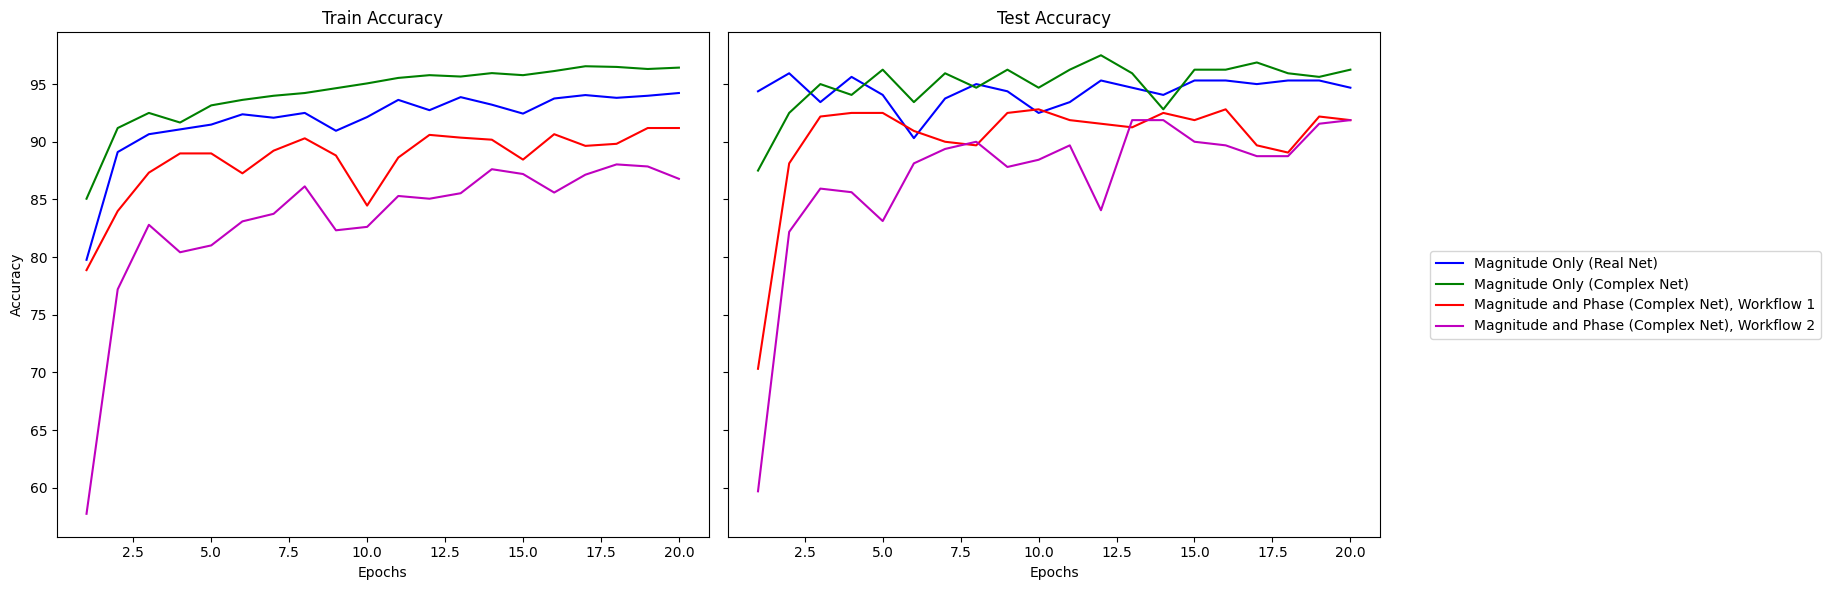

In [40]:
# Data for the four scenarios
data = {
    "Magnitude Only (Real Net)": metrics_dict_e1,
    "Magnitude Only (Complex Net)": metrics_dict_e2,
    "Magnitude and Phase (Complex Net), Workflow 1": metrics_dict_e3,
    "Magnitude and Phase (Complex Net), Workflow 2": metrics_dict_e4
}
# Data for plotting
epochs = range(1, 21)
colors = ['b', 'g', 'r', 'm', 'y']
scenarios = list(data.keys())
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
# Plot Train Accuracy
for i, scenario in enumerate(scenarios):
    axes[0].plot(epochs, data[scenario]["train_accuracies"], label=scenario, color=colors[i])
axes[0].set_title("Train Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
# Plot Test Accuracy
for i, scenario in enumerate(scenarios):
    axes[1].plot(epochs, data[scenario]["test_accuracies"], label=scenario, color=colors[i])
axes[1].set_title("Test Accuracy")
axes[1].set_xlabel("Epochs")
fig.legend(scenarios, loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()

# fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# for i, scenario in enumerate(scenarios):
#     axes[0].plot(epochs, data[scenario]["train_losses"], label=scenario, color=colors[i])

# axes[0].set_title("Train Loss")
# axes[0].set_xlabel("Epochs")
# axes[0].set_ylabel("Train Loss")
# axes[0].legend()

# for i, scenario in enumerate(scenarios):
#     axes[1].plot(epochs, data[scenario]["test_losses"], label=scenario, color=colors[i])

# axes[1].set_title("Test Loss")
# axes[1].set_xlabel("Epochs")
# axes[1].set_ylabel("Test Loss")
# axes[1].legend()

# plt.tight_layout()
# plt.show()

# fig, axes = plt.subplots(1, 1, figsize=(10, 5))
# for i, scenario in enumerate(scenarios):
#     axes.plot(epochs, data[scenario]["epoch_times"], label=scenario, color=colors[i])
# axes.set_title("Time")
# axes.set_xlabel("Epochs")
# axes.set_ylabel("Time (secs)")
# axes.legend()


### Activation Comparison

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import pandas as pd

# ---------- Complex Activation Functions ----------
def complex_relu(z):
    return F.relu(z.real).type(torch.complex64) + 1j * F.relu(z.imag).type(torch.complex64)

def modrelu(z, b=0.1):
    magnitude = torch.abs(z)
    phase = z / (magnitude + 1e-8)
    scale = F.relu(magnitude + b)
    return scale * phase

def zrelu(z):
    mask = (z.real >= 0) & (z.imag >= 0)
    return z * mask

def smooth_zrelu(z, alpha=0.1):
    real_mask = torch.sigmoid(alpha * z.real)
    imag_mask = torch.sigmoid(alpha * z.imag)
    smooth_mask = real_mask * imag_mask
    return z * smooth_mask

def split_tanh(z):
    return torch.tanh(z.real).type(torch.complex64) + 1j * torch.tanh(z.imag).type(torch.complex64)

def complex_cardioid(z, eps=1e-5):
    norm = torch.abs(z)
    cos_phase = z.real / (norm + eps)
    scale = 0.5 * (1 + cos_phase)
    return z * scale

# ---------- Model ----------
class ComplexNet(nn.Module):
    def __init__(self, activation_fn):
        super(ComplexNet, self).__init__()
        self.activation_fn = activation_fn
        self.conv1 = ComplexConv2d(1, 10, 2, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 2, 1)
        self.fc1 = ComplexLinear(30 * 2 * 20, 500)
        self.fc2 = ComplexLinear(500, 2)
             
    def forward(self, x):
        x = self.conv1(x)
        x = self.activation_fn(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = self.activation_fn(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(-1, 30 * 2 * 20)
        x = self.fc1(x)
        x = self.activation_fn(x)
        x = self.fc2(x)
        x = x.abs()
        x = F.log_softmax(x, dim=1)
        return x

# ---------- Evaluation ----------
def evaluate_activation_on_dataset(activation_name, activation_fn, train_loader, test_loader, NUM_EPOCHS=10):
    model = ComplexNet(activation_fn).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    metrics_dict = {
        'epoch_times': [],
        'train_losses': [],
        'train_accuracies': [],
        'test_losses': [],
        'test_accuracies': []
    }

    for epoch in range(NUM_EPOCHS):
        print(f"[{activation_name}] Epoch {epoch + 1}/{NUM_EPOCHS}")
        train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict,
              complexify=True, data_fn=None)  # No data_fn used here

    return {
        'Activation': activation_name,
        'Train Loss': sum(metrics_dict['train_losses']) / NUM_EPOCHS,
        'Train Accuracy': sum(metrics_dict['train_accuracies']) / NUM_EPOCHS,
        'Test Loss': sum(metrics_dict['test_losses']) / NUM_EPOCHS,
        'Test Accuracy': sum(metrics_dict['test_accuracies']) / NUM_EPOCHS,
        'Avg Epoch Time (s)': sum(metrics_dict['epoch_times']) / NUM_EPOCHS
    }

# ---------- Activation Setup ----------
activation_functions = {
    "CReLU": complex_relu,
    "modReLU": lambda z: modrelu(z, b=0.1),
    "zReLU": smooth_zrelu,
    "split_tanh": split_tanh,
    "cardioid": complex_cardioid
}

# ---------- Run on All 3 Datasets ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64  # define as needed

results = []

# Dataset variants
dataset_variants = {
    "MFCC": GenreDatasetMFCC,
    "PhaseMFCC": GenreDatasetPhaseMFCC,
    "PhaseMFCC2": GenreDatasetPhaseMFCC2
}

In [ ]:
activation_name = "CReLU"
activation_fn = complex_relu

results = []
for dataset_name, DatasetClass in dataset_variants.items():
    print(f"\n=== {activation_name} on {dataset_name} ===")
    
    train_dataset = DatasetClass("data/music_genre_binary_data/train/", n_fft=2048, hop_length=512, num_segments=10,
                                 mel_filter_num=13, dct_filter_num=13, training=True)
    test_dataset = DatasetClass("data/music_genre_binary_data/test/", n_fft=2048, hop_length=512, num_segments=10,
                                mel_filter_num=13, dct_filter_num=13, training=False)

    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)

    result = evaluate_activation_on_dataset(activation_name, activation_fn, train_loader, test_loader)
    result["Dataset"] = dataset_name
    results.append(result)
    
df_crelu = pd.DataFrame(results)


=== CReLU on MFCC ===
[CReLU] Epoch 1/10
Train Epoch:   0 [     0/  1680 (  0%)]	Loss: 0.756921	Accuracy: 39.06%
Train Epoch:   0 [   640/  1680 ( 38%)]	Loss: 0.277752	Accuracy: 75.99%
Train Epoch:   0 [  1280/  1680 ( 77%)]	Loss: 0.207249	Accuracy: 83.11%
Epoch 0 - Time: 38.76s - Train Loss: 0.366772 - Train Accuracy: 82.80%
Test Loss: 1.059133 - Test Accuracy: 67.81%

[CReLU] Epoch 2/10
Train Epoch:   1 [     0/  1680 (  0%)]	Loss: 0.979431	Accuracy: 76.56%
Train Epoch:   1 [   640/  1680 ( 38%)]	Loss: 0.200988	Accuracy: 88.64%
Train Epoch:   1 [  1280/  1680 ( 77%)]	Loss: 0.404490	Accuracy: 90.03%
Epoch 1 - Time: 37.79s - Train Loss: 0.275740 - Train Accuracy: 89.40%
Test Loss: 0.145624 - Test Accuracy: 94.38%

[CReLU] Epoch 3/10
Train Epoch:   2 [     0/  1680 (  0%)]	Loss: 0.125717	Accuracy: 93.75%
Train Epoch:   2 [   640/  1680 ( 38%)]	Loss: 0.066568	Accuracy: 93.89%
Train Epoch:   2 [  1280/  1680 ( 77%)]	Loss: 0.243586	Accuracy: 93.82%
Epoch 2 - Time: 38.24s - Train Loss: 0.1

In [ ]:
activation_name = "modReLU"
activation_fn = lambda z: modrelu(z, b=0.1)

results = []
for dataset_name, DatasetClass in dataset_variants.items():
    print(f"\n=== {activation_name} on {dataset_name} ===")

    train_dataset = DatasetClass("data/music_genre_binary_data/train/", n_fft=2048, hop_length=512, num_segments=10,
                                 mel_filter_num=13, dct_filter_num=13, training=True)
    test_dataset = DatasetClass("data/music_genre_binary_data/test/", n_fft=2048, hop_length=512, num_segments=10,
                                mel_filter_num=13, dct_filter_num=13, training=False)

    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)

    result = evaluate_activation_on_dataset(activation_name, activation_fn, train_loader, test_loader)
    result["Dataset"] = dataset_name
    results.append(result)

df_modrelu = pd.DataFrame(results)


=== modReLU on MFCC ===
[modReLU] Epoch 1/10
Train Epoch:   0 [     0/  1680 (  0%)]	Loss: 0.662621	Accuracy: 62.50%
Train Epoch:   0 [   640/  1680 ( 38%)]	Loss: 0.605827	Accuracy: 63.92%
Train Epoch:   0 [  1280/  1680 ( 77%)]	Loss: 21.014284	Accuracy: 60.49%
Epoch 0 - Time: 49.53s - Train Loss: 18.347362 - Train Accuracy: 56.07%
Test Loss: 128.024632 - Test Accuracy: 50.00%

[modReLU] Epoch 2/10
Train Epoch:   1 [     0/  1680 (  0%)]	Loss: 88.990089	Accuracy: 51.56%
Train Epoch:   1 [   640/  1680 ( 38%)]	Loss: nan	Accuracy: 48.01%
Train Epoch:   1 [  1280/  1680 ( 77%)]	Loss: nan	Accuracy: 48.29%
Epoch 1 - Time: 47.97s - Train Loss: nan - Train Accuracy: 48.63%
Test Loss: nan - Test Accuracy: 50.00%

[modReLU] Epoch 3/10
Train Epoch:   2 [     0/  1680 (  0%)]	Loss: nan	Accuracy: 48.44%
Train Epoch:   2 [   640/  1680 ( 38%)]	Loss: nan	Accuracy: 48.58%
Train Epoch:   2 [  1280/  1680 ( 77%)]	Loss: nan	Accuracy: 49.63%
Epoch 2 - Time: 48.64s - Train Loss: nan - Train Accuracy: 49.

In [ ]:
activation_name = "zReLU"
activation_fn = smooth_zrelu  # smoothed version

results = []
for dataset_name, DatasetClass in dataset_variants.items():
    print(f"\n=== {activation_name} on {dataset_name} ===")

    train_dataset = DatasetClass("data/music_genre_binary_data/train/", n_fft=2048, hop_length=512, num_segments=10,
                                 mel_filter_num=13, dct_filter_num=13, training=True)
    test_dataset = DatasetClass("data/music_genre_binary_data/test/", n_fft=2048, hop_length=512, num_segments=10,
                                mel_filter_num=13, dct_filter_num=13, training=False)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)

    result = evaluate_activation_on_dataset(activation_name, activation_fn, train_loader, test_loader)
    result["Dataset"] = dataset_name
    results.append(result)

df_zrelu = pd.DataFrame(results)


=== zReLU on MFCC ===
[zReLU] Epoch 1/10
Train Epoch:   0 [     0/  1680 (  0%)]	Loss: 0.689235	Accuracy: 64.06%
Train Epoch:   0 [   640/  1680 ( 38%)]	Loss: 0.521641	Accuracy: 80.82%
Train Epoch:   0 [  1280/  1680 ( 77%)]	Loss: 0.414517	Accuracy: 84.15%
Epoch 0 - Time: 47.87s - Train Loss: 0.493300 - Train Accuracy: 84.46%
Test Loss: 0.277673 - Test Accuracy: 91.25%

[zReLU] Epoch 2/10
Train Epoch:   1 [     0/  1680 (  0%)]	Loss: 0.291221	Accuracy: 89.06%
Train Epoch:   1 [   640/  1680 ( 38%)]	Loss: 0.247307	Accuracy: 91.90%
Train Epoch:   1 [  1280/  1680 ( 77%)]	Loss: 0.257618	Accuracy: 91.15%
Epoch 1 - Time: 46.09s - Train Loss: 0.250907 - Train Accuracy: 90.06%
Test Loss: 0.325466 - Test Accuracy: 85.94%

[zReLU] Epoch 3/10
Train Epoch:   2 [     0/  1680 (  0%)]	Loss: 0.137704	Accuracy: 96.88%
Train Epoch:   2 [   640/  1680 ( 38%)]	Loss: 0.288787	Accuracy: 91.05%
Train Epoch:   2 [  1280/  1680 ( 77%)]	Loss: 0.148405	Accuracy: 90.85%
Epoch 2 - Time: 45.07s - Train Loss: 0.2

In [ ]:
activation_name = "split_tanh"
activation_fn = split_tanh

results = []
for dataset_name, DatasetClass in dataset_variants.items():
    print(f"\n=== {activation_name} on {dataset_name} ===")

    train_dataset = DatasetClass("data/music_genre_binary_data/train/", n_fft=2048, hop_length=512, num_segments=10,
                                 mel_filter_num=13, dct_filter_num=13, training=True)
    test_dataset = DatasetClass("data/music_genre_binary_data/test/", n_fft=2048, hop_length=512, num_segments=10,
                                mel_filter_num=13, dct_filter_num=13, training=False)

    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)

    result = evaluate_activation_on_dataset(activation_name, activation_fn, train_loader, test_loader)
    result["Dataset"] = dataset_name
    results.append(result)

df_split_tanh = pd.DataFrame(results)


=== split_tanh on MFCC ===
[split_tanh] Epoch 1/10
Train Epoch:   0 [     0/  1680 (  0%)]	Loss: 0.670944	Accuracy: 57.81%
Train Epoch:   0 [   640/  1680 ( 38%)]	Loss: 0.396008	Accuracy: 77.56%
Train Epoch:   0 [  1280/  1680 ( 77%)]	Loss: 0.169495	Accuracy: 81.77%
Epoch 0 - Time: 42.38s - Train Loss: 0.390341 - Train Accuracy: 81.67%
Test Loss: 0.372859 - Test Accuracy: 84.06%

[split_tanh] Epoch 2/10
Train Epoch:   1 [     0/  1680 (  0%)]	Loss: 0.340123	Accuracy: 85.94%
Train Epoch:   1 [   640/  1680 ( 38%)]	Loss: 0.189511	Accuracy: 89.63%
Train Epoch:   1 [  1280/  1680 ( 77%)]	Loss: 0.219288	Accuracy: 91.44%
Epoch 1 - Time: 43.95s - Train Loss: 0.233800 - Train Accuracy: 90.60%
Test Loss: 0.233765 - Test Accuracy: 90.62%

[split_tanh] Epoch 3/10
Train Epoch:   2 [     0/  1680 (  0%)]	Loss: 0.126933	Accuracy: 95.31%
Train Epoch:   2 [   640/  1680 ( 38%)]	Loss: 0.213820	Accuracy: 93.32%
Train Epoch:   2 [  1280/  1680 ( 77%)]	Loss: 0.147383	Accuracy: 93.15%
Epoch 2 - Time: 44.8

In [ ]:
activation_name = "cardioid"
activation_fn = complex_cardioid

results = []
for dataset_name, DatasetClass in dataset_variants.items():
    print(f"\n=== {activation_name} on {dataset_name} ===")

    train_dataset = DatasetClass("data/music_genre_binary_data/train/", n_fft=2048, hop_length=512, num_segments=10,
                                 mel_filter_num=13, dct_filter_num=13, training=True)
    test_dataset = DatasetClass("data/music_genre_binary_data/test/", n_fft=2048, hop_length=512, num_segments=10,
                                mel_filter_num=13, dct_filter_num=13, training=False)

    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)

    result = evaluate_activation_on_dataset(activation_name, activation_fn, train_loader, test_loader)
    result["Dataset"] = dataset_name
    results.append(result)

df_cardioid = pd.DataFrame(results)


=== cardioid on MFCC ===
[cardioid] Epoch 1/10
Train Epoch:   0 [     0/  1680 (  0%)]	Loss: 0.655883	Accuracy: 65.62%
Train Epoch:   0 [   640/  1680 ( 38%)]	Loss: 0.386384	Accuracy: 84.23%
Train Epoch:   0 [  1280/  1680 ( 77%)]	Loss: 0.147670	Accuracy: 85.49%
Epoch 0 - Time: 42.33s - Train Loss: 0.358385 - Train Accuracy: 85.36%
Test Loss: 0.175641 - Test Accuracy: 95.62%

[cardioid] Epoch 2/10
Train Epoch:   1 [     0/  1680 (  0%)]	Loss: 0.194063	Accuracy: 92.19%
Train Epoch:   1 [   640/  1680 ( 38%)]	Loss: 0.190206	Accuracy: 91.19%
Train Epoch:   1 [  1280/  1680 ( 77%)]	Loss: 0.125621	Accuracy: 92.11%
Epoch 1 - Time: 45.67s - Train Loss: 0.206152 - Train Accuracy: 91.49%
Test Loss: 0.185062 - Test Accuracy: 95.00%

[cardioid] Epoch 3/10
Train Epoch:   2 [     0/  1680 (  0%)]	Loss: 0.103309	Accuracy: 95.31%
Train Epoch:   2 [   640/  1680 ( 38%)]	Loss: 0.128121	Accuracy: 93.18%
Train Epoch:   2 [  1280/  1680 ( 77%)]	Loss: 0.105925	Accuracy: 93.08%
Epoch 2 - Time: 46.44s - Tra

In [54]:
df_all = pd.concat([df_crelu, df_modrelu, df_zrelu, df_split_tanh, df_cardioid], ignore_index=True)
print(df_all)

    Activation  Train Loss  Train Accuracy  Test Loss  Test Accuracy  \
0        CReLU    0.175428       92.238095   0.267061       92.31250   
1        CReLU    0.317981       85.392857   0.263213       90.28125   
2        CReLU    0.471153       76.261905   0.414570       78.78125   
3      modReLU         NaN       52.773810        NaN       50.65625   
4      modReLU    0.635271       80.875000   0.736031       82.56250   
5      modReLU    0.953345       52.744048   0.904418       54.34375   
6        zReLU    0.227199       90.898810   0.223432       92.00000   
7        zReLU    0.315016       86.684524   0.325821       88.09375   
8        zReLU    0.474823       76.880952   0.445952       78.06250   
9   split_tanh    0.200349       91.208333   0.256032       90.84375   
10  split_tanh    0.479754       77.059524   0.443970       79.65625   
11  split_tanh    0.719872       55.196429   0.752671       52.71875   
12    cardioid    0.156633       93.178571   0.171832       95.3

# Experiment 3: GNN

In [64]:
# Complex pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from complexPyTorch.complexLayers import *
from complexPyTorch.complexFunctions import *
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load Data
import numpy as np
import json
import os
import math
import librosa
import pathlib
from scipy.spatial.distance import cdist
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import random

# MFCCS
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window

In [65]:
class GNNMusicFeatureExtractorComplex2:
    def __init__(self, FFT_size=2048, HOP_SIZE=512, mel_filter_num=13, dct_filter_num=40):
        self.FFT_size = FFT_size
        self.HOP_SIZE = HOP_SIZE
        self.mel_filter_num = mel_filter_num
        self.dct_filter_num = dct_filter_num
        self.epsilon = 1e-10  # Added to log to avoid log10(0)

    def normalize_audio(self, audio):
        audio = audio / np.max(np.abs(audio))
        return audio

    def frame_audio(self, audio):
        frame_num = int((len(audio) - self.FFT_size) / self.HOP_SIZE) + 1
        frames = np.zeros((frame_num, self.FFT_size))
        for n in range(frame_num):
            frames[n] = audio[n * self.HOP_SIZE: n * self.HOP_SIZE + self.FFT_size]
        return frames

    def freq_to_mel(self, freq):
        return 2595.0 * np.log10(1.0 + freq / 700.0)

    def met_to_freq(self, mels):
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

    def get_filter_points(self, fmin, fmax, sample_rate):
        fmin_mel = self.freq_to_mel(fmin)
        fmax_mel = self.freq_to_mel(fmax)
        mels = np.linspace(fmin_mel, fmax_mel, num=self.mel_filter_num + 2)
        freqs = self.met_to_freq(mels)
        return np.floor((self.FFT_size + 1) / sample_rate * freqs).astype(int), freqs

    def get_filters(self, filter_points):
        filters = np.zeros((len(filter_points) - 2, int(self.FFT_size / 2 + 1)))
        for n in range(len(filter_points) - 2):
            filters[n, filter_points[n]: filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
            filters[n, filter_points[n + 1]: filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
        return filters

    def dct(self):
        basis = np.empty((self.dct_filter_num, self.mel_filter_num))
        basis[0, :] = 1.0 / np.sqrt(self.mel_filter_num)
        samples = np.arange(1, 2 * self.mel_filter_num, 2) * np.pi / (2.0 * self.mel_filter_num)
        for i in range(1, self.dct_filter_num):
            basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / self.mel_filter_num)
        return basis

    def get_mfcc_features(self, audio, sample_rate):
        audio = self.normalize_audio(audio)
        audio_framed = self.frame_audio(audio)
        window = get_window("hann", self.FFT_size, fftbins=True)
        audio_win = audio_framed * window
        audio_winT = np.transpose(audio_win)
        audio_fft = np.empty((int(1 + self.FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')
        for n in range(audio_fft.shape[1]):
            audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]
        audio_fft = np.transpose(audio_fft)
        mag_fft = np.square(np.abs(audio_fft))
        phase_fft = np.angle(audio_fft)
        freq_min = 0
        freq_high = sample_rate / 2
        filter_points, mel_freqs = self.get_filter_points(freq_min, freq_high, sample_rate)
        filters = self.get_filters(filter_points)
        audio_filtered = np.dot(filters, np.transpose(mag_fft))
        phase_filtered = np.dot(filters, np.transpose(phase_fft))
        audio_filtered = np.maximum(audio_filtered, self.epsilon)  # Replace zero values with epsilon
        audio_log = 10.0 * np.log10(audio_filtered)
        dct_filters = self.dct()
        cepstral_coefficents = np.dot(dct_filters, audio_log)
        phase_coefficents = np.dot(dct_filters, phase_filtered)
        return np.array([cepstral_coefficents]), np.array([phase_coefficents])
    
class GNNGenreDatasetMFCC(Dataset):

    def __init__(self, train_path, n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=40, training = True):
        cur_path = pathlib.Path(train_path)
        self.files = []
        for i in list(cur_path.rglob("*.wav")):
            for j in range(num_segments):
                self.files.append([j, i])
        self.samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.num_segments = num_segments
        self.dct_filter_num = dct_filter_num
        self.training = training

    def apply_augmentations(self, signal):
        # Apply augmentations to the audio signal
        if random.random() < 0.5:
            signal = librosa.effects.pitch_shift(signal, sr=SAMPLE_RATE, n_steps=random.uniform(-2, 2))
        if random.random() < 0.5:
            signal = librosa.effects.time_stretch(signal, rate=random.uniform(0.8, 1.2))
        return signal

    def adjust_shape(self, sequence, max_sequence_length = 126):
        current_length = sequence.shape[2]
        if current_length < max_sequence_length:
            padding = np.zeros((1, 13, max_sequence_length - current_length))
            padded_sequence = np.concatenate((sequence, padding), axis=2)
        else:
            padded_sequence = sequence[:, :, :max_sequence_length]
        return padded_sequence
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        cur_file = self.files[idx]
        d = cur_file[0]
        file_path = cur_file[1]
        target = genre_mappings[str(file_path).split("/")[3]]
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
        start = self.samples_per_segment * d
        finish = start + self.samples_per_segment
        cur_signal = signal[start:finish]
        if self.training: cur_signal = self.apply_augmentations(cur_signal)
        cur_mfcc = self.mfcc_extractor.get_mfcc_features(cur_signal, sample_rate)  # Use the MusicFeatureExtractor to get MFCC features
        cur_mfcc = self.adjust_shape(cur_mfcc)
        return torch.tensor(cur_mfcc, dtype=torch.float32), target

class GNNGenreDatasetPhaseMFCC2(GNNGenreDatasetMFCC):

    def __init__(self, train_path, n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=40, training = True):
        super().__init__(train_path, n_fft, hop_length, num_segments, mel_filter_num, dct_filter_num, training)
        self.mfcc_extractor = GNNMusicFeatureExtractorComplex2(
            FFT_size=n_fft, HOP_SIZE=hop_length, mel_filter_num = mel_filter_num, dct_filter_num = dct_filter_num)
        
    def __getitem__(self, idx):
        cur_file = self.files[idx]
        d = cur_file[0]
        file_path = cur_file[1]
        target = genre_mappings[str(file_path).split("/")[3]]
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
        start = self.samples_per_segment * d
        finish = start + self.samples_per_segment
        cur_signal = signal[start:finish]
        if self.training: cur_signal = self.apply_augmentations(cur_signal)
        cur_mfcc, cur_phase = self.mfcc_extractor.get_mfcc_features(cur_signal, sample_rate)  # Use the MusicFeatureExtractor to get MFCC features
        cur_mfcc, cur_phase = self.adjust_shape(cur_mfcc), self.adjust_shape(cur_phase)
        return torch.tensor(cur_mfcc, dtype=torch.float32), torch.tensor(cur_phase, dtype=torch.float32), target

In [ ]:
train_dataset = GNNGenreDatasetPhaseMFCC2("data/music_genre_binary_data/train/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13)
test_dataset = GNNGenreDatasetPhaseMFCC2("data/music_genre_binary_data/test/", n_fft=2048, hop_length=512, num_segments=10, mel_filter_num=13, dct_filter_num=13)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)

In [71]:
def train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = len(train_loader.dataset)
    start_time = time.time()
    
    for batch_idx, (data, data2, target) in enumerate(train_loader):
        data, data2, target = data.to(device), data2.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 10 == 0:
            batch_accuracy = 100. * correct / ((batch_idx + 1) * len(data))
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch,
                batch_idx * len(data),
                total_samples,
                100. * batch_idx / len(train_loader),
                loss.item(),
                batch_accuracy)
            )
    
    end_time = time.time()
    epoch_times = metrics_dict['epoch_times']
    epoch_times.append(end_time - start_time)
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total_samples
    train_losses = metrics_dict['train_losses']
    train_accuracies = metrics_dict['train_accuracies']
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print('Epoch {} - Time: {:.2f}s - Train Loss: {:.6f} - Train Accuracy: {:.2f}%'.format(epoch, epoch_times[-1], epoch_loss, epoch_accuracy))
    
    # Evaluate on test data
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, data2, target in test_loader:
            data, data2, target = data.to(device), data2.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses = metrics_dict['test_losses']
    test_accuracies = metrics_dict['test_accuracies']
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))

BATCH_SIZE = 64
NUM_EPOCHS = 20

## 1. Simple Graph Net (Only magnitude)

In [72]:
class ComplexGraphNet(nn.Module):
    def __init__(self):
        super(ComplexGraphNet, self).__init__()
        self.gnn_layer = GCNConv(in_channels=126, out_channels=126, node_dim = 1)  # GNN layer
        self.conv1 = ComplexConv2d(1, 10, 2, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 2, 1)
        self.fc1 = ComplexLinear(30*2*20, 500)
        self.fc2 = ComplexLinear(500, 2)

    def forward(self, x):  # Pass edge_index for GNN
        batch_size, _, num_nodes, node_size = x.size()
        edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t()
        x = x.view(-1, num_nodes, node_size)  # Reshape for batch processing
        x = self.gnn_layer(x, edge_index)
        x = x.unsqueeze(1)
        
        x = x.type(torch.complex64)
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(batch_size, -1)  # Reshape back to batched form
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x = F.log_softmax(x, dim=1)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexGraphNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e5 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e5)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e5.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  1680 (  0%)]	Loss: 0.705714	Accuracy: 50.00%
Train Epoch:   0 [   640/  1680 ( 38%)]	Loss: 0.600486	Accuracy: 53.69%
Train Epoch:   0 [  1280/  1680 ( 77%)]	Loss: 0.529642	Accuracy: 63.99%
Epoch 0 - Time: 639.91s - Train Loss: 0.737660 - Train Accuracy: 65.36%
Test Loss: 0.688564 - Test Accuracy: 66.56%

Train Epoch:   1 [     0/  1680 (  0%)]	Loss: 0.552402	Accuracy: 79.69%
Train Epoch:   1 [   640/  1680 ( 38%)]	Loss: 0.566071	Accuracy: 75.99%
Train Epoch:   1 [  1280/  1680 ( 77%)]	Loss: 0.541122	Accuracy: 76.41%
Epoch 1 - Time: 865.63s - Train Loss: 0.530767 - Train Accuracy: 75.18%
Test Loss: 0.522656 - Test Accuracy: 77.81%

Train Epoch:   2 [     0/  1680 (  0%)]	Loss: 0.461788	Accuracy: 79.69%
Train Epoch:   2 [   640/  1680 ( 38%)]	Loss: 0.574799	Accuracy: 79.40%
Train Epoch:   2 [  1280/  1680 ( 77%)]	Loss: 0.564111	Accuracy: 77.98%
Epoch 2 - Time: 728.59s - Train Loss: 0.490062 - Train Accuracy: 76.31%
Test Loss: 0.497871 - Test Accuracy: 75.62%

T

## 2. Simple Graph Net (Magnitude + phase weights)

In [75]:
def train(model, device, train_loader, test_loader, optimizer, epoch, metrics_dict):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = len(train_loader.dataset)
    start_time = time.time()
    
    for batch_idx, (data, data2, target) in enumerate(train_loader):
        data, data2, target = data.to(device), data2.to(device), target.to(device)
        optimizer.zero_grad()
        output = model([data, data2])
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 10 == 0:
            batch_accuracy = 100. * correct / ((batch_idx + 1) * len(data))
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch,
                batch_idx * len(data),
                total_samples,
                100. * batch_idx / len(train_loader),
                loss.item(),
                batch_accuracy)
            )
    
    end_time = time.time()
    epoch_times = metrics_dict['epoch_times']
    epoch_times.append(end_time - start_time)
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total_samples
    train_losses = metrics_dict['train_losses']
    train_accuracies = metrics_dict['train_accuracies']
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print('Epoch {} - Time: {:.2f}s - Train Loss: {:.6f} - Train Accuracy: {:.2f}%'.format(epoch, epoch_times[-1], epoch_loss, epoch_accuracy))
    
    # Evaluate on test data
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, data2, target in test_loader:
            data, data2, target = data.to(device), data2.to(device), target.to(device)
            output = model([data, data2])
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses = metrics_dict['test_losses']
    test_accuracies = metrics_dict['test_accuracies']
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%\n'.format(test_loss, test_accuracy))

In [76]:
class ComplexGraphNet(nn.Module):
    def __init__(self):
        super(ComplexGraphNet, self).__init__()
        self.gnn_layer = GCNConv(in_channels=126, out_channels=126, node_dim = 1)  # GNN layer
        self.conv1 = ComplexConv2d(1, 10, 2, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 2, 1)
        self.fc1 = ComplexLinear(30*2*20, 500)
        self.fc2 = ComplexLinear(500, 2)

    def forward(self, x):  # Pass edge_index for GNN
        x, phase_data = x[0], x[1]
        batch_size, _, num_nodes, node_size = x.size()
        edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t()
        phase_data = torch.mean(phase_data.view(-1, num_nodes, node_size), axis = 0)
        edge_weight = torch.tensor([torch.mean(np.abs(phase_data[edge_index[0][i].item()] - 
                                                      phase_data[edge_index[1][i].item()])).item() 
                                    for i in range(len(edge_index[0]))])
        x = x.view(-1, num_nodes, node_size)  # Reshape for batch processing
        x = self.gnn_layer(x, edge_index, edge_weight)
        x = x.unsqueeze(1)
        
        x = x.type(torch.complex64)
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(batch_size, -1)  # Reshape back to batched form
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x = F.log_softmax(x, dim=1)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexGraphNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

metrics_dict_e6 = {
    'epoch_times': [],
    'train_losses': [],
    'train_accuracies': [],
    'test_losses': [],
    'test_accuracies': []
}

for epoch in range(NUM_EPOCHS):
    train(model, 
          device, 
          train_loader, 
          test_loader, 
          optimizer, 
          epoch, 
          metrics_dict_e6)

print("-"*100)
print("-"*100)
print("FINAL RESULTS:")
print("-"*100)
for key, value in metrics_dict_e6.items():
    print(f'{key}: {value}')

Train Epoch:   0 [     0/  1680 (  0%)]	Loss: 0.704152	Accuracy: 48.44%
Train Epoch:   0 [   640/  1680 ( 38%)]	Loss: 1.461232	Accuracy: 47.87%
Train Epoch:   0 [  1280/  1680 ( 77%)]	Loss: 0.561671	Accuracy: 51.79%
Epoch 0 - Time: 738.49s - Train Loss: 1.157114 - Train Accuracy: 55.06%
Test Loss: 0.571363 - Test Accuracy: 69.06%

Train Epoch:   1 [     0/  1680 (  0%)]	Loss: 0.519094	Accuracy: 71.88%
Train Epoch:   1 [   640/  1680 ( 38%)]	Loss: 0.623816	Accuracy: 71.59%
Train Epoch:   1 [  1280/  1680 ( 77%)]	Loss: 0.483718	Accuracy: 73.44%
Epoch 1 - Time: 769.39s - Train Loss: 0.544129 - Train Accuracy: 71.31%
Test Loss: 0.579457 - Test Accuracy: 68.44%

Train Epoch:   2 [     0/  1680 (  0%)]	Loss: 0.476125	Accuracy: 78.12%
Train Epoch:   2 [   640/  1680 ( 38%)]	Loss: 0.362115	Accuracy: 82.67%
Train Epoch:   2 [  1280/  1680 ( 77%)]	Loss: 0.388000	Accuracy: 80.43%
Epoch 2 - Time: 750.89s - Train Loss: 0.457919 - Train Accuracy: 79.05%
Test Loss: 0.725640 - Test Accuracy: 58.12%

T

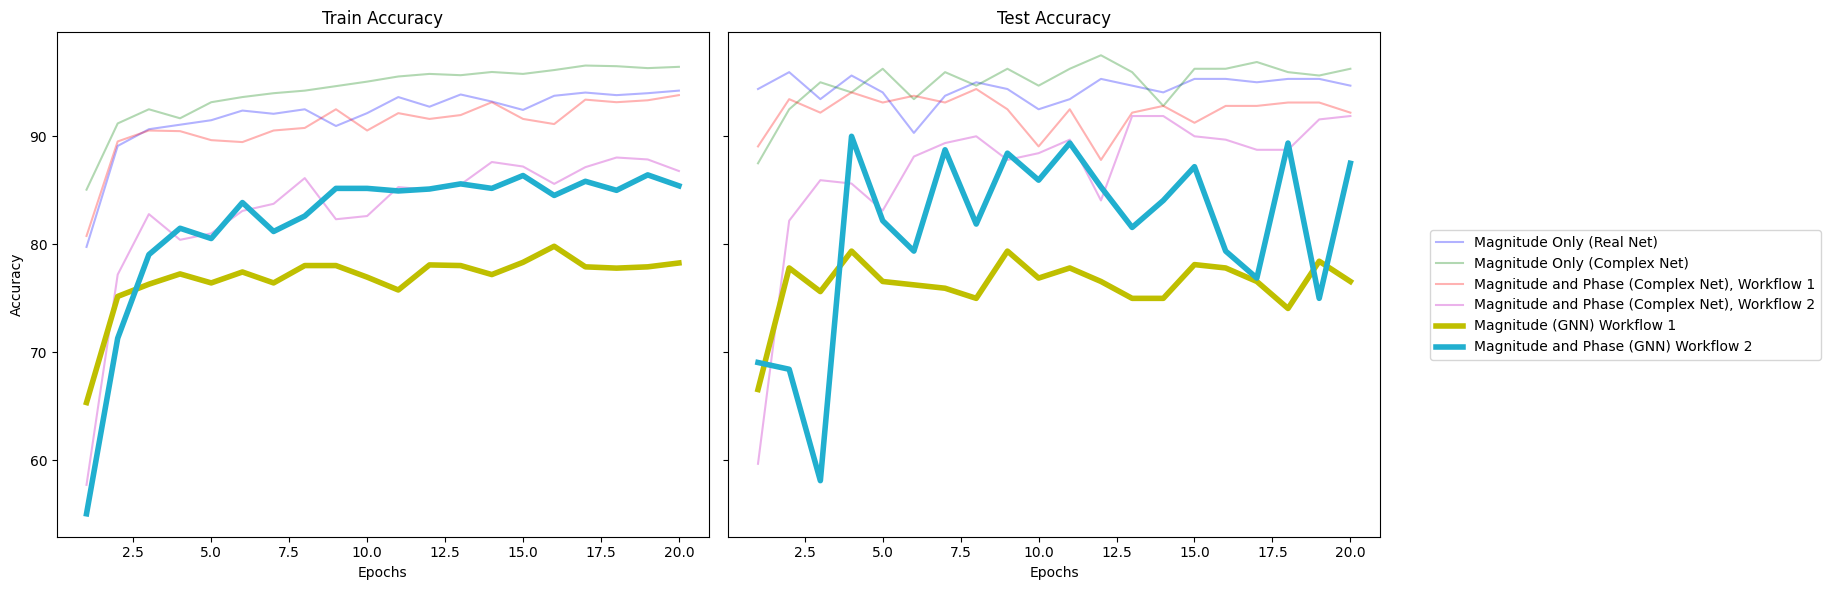

In [83]:
# Data for the four scenarios
data = {
    "Magnitude Only (Real Net)": metrics_dict_e1,
    "Magnitude Only (Complex Net)": metrics_dict_e2,
    "Magnitude and Phase (Complex Net), Workflow 1": metrics_dict_e3,
    "Magnitude and Phase (Complex Net), Workflow 2": metrics_dict_e4,
    "Magnitude (GNN) Workflow 1": metrics_dict_e5,
    "Magnitude and Phase (GNN) Workflow 2": metrics_dict_e6,
}

# Data for plotting
epochs = range(1, 21)
colors = ['b', 'g', 'r', 'm', 'y', "#21AFCF"]
scenarios = list(data.keys())
# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
# Plot Train Accuracy
# Plot Train Accuracy
for i, scenario in enumerate(scenarios):
    alpha = 1.0 if i >= 4 else 0.3
    lw = 4 if i >= 4 else 1.5  # Make last two lines thicker
    axes[0].plot(epochs, data[scenario]["train_accuracies"], label=scenario, color=colors[i], linewidth=lw, alpha=alpha)
axes[0].set_title("Train Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
# Plot Test Accuracy
for i, scenario in enumerate(scenarios):
    alpha = 1.0 if i >= 4 else 0.3
    lw = 4 if i >= 4 else 1.5  # Make last two lines thicker
    axes[1].plot(epochs, data[scenario]["test_accuracies"], label=scenario, color=colors[i], linewidth=lw, alpha=alpha)
axes[1].set_title("Test Accuracy")
axes[1].set_xlabel("Epochs")
fig.legend(scenarios, loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()

# fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# for i, scenario in enumerate(scenarios):
#     axes[0].plot(epochs, data[scenario]["train_losses"], label=scenario, color=colors[i])

# axes[0].set_title("Train Loss")
# axes[0].set_xlabel("Epochs")
# axes[0].set_ylabel("Train Loss")
# axes[0].legend()

# for i, scenario in enumerate(scenarios):
#     axes[1].plot(epochs, data[scenario]["test_losses"], label=scenario, color=colors[i])

# axes[1].set_title("Test Loss")
# axes[1].set_xlabel("Epochs")
# axes[1].set_ylabel("Test Loss")
# axes[1].legend()

# plt.tight_layout()
# plt.show()

# fig, axes = plt.subplots(1, 1, figsize=(10, 5))
# for i, scenario in enumerate(scenarios):
#     axes.plot(epochs, data[scenario]["epoch_times"], label=scenario, color=colors[i])
# axes.set_title("Time")
# axes.set_xlabel("Epochs")
# axes.set_ylabel("Time (secs)")
# axes.legend()